In [1]:
# !pip install --upgrade pyarrow
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:

import pandas as pd
import numpy as np
import math
import re
import time
import os

from numpy.random import randint
from numpy.random import rand

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import wait

import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
# simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=ConvergenceWarning)#LogisticRegression

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Generate features

In [4]:
categorical_col = ['Sex','Embarked','Pclass']
numerical_col =  ['Fare', 'Age', 'SibSp', 'Parch']

In [5]:
#Transform Cabin column
def cabin_features(data):
  col = 'Cabin'
  features = pd.DataFrame(data[col])
  for index, cell in enumerate(features[col]):
    params = set()
    for cabins in str(cell).split(' '):
      for p in filter(None,re.split(r'(\d+)', cabins)):
        params.add(p.strip())
    for cabin in params:
      cabin = col + '_' + cabin # including NaN
      if(cabin not in features.columns):
        features[cabin] = 0
      features.at[index, cabin] = 1
  features.drop(col, axis=1, inplace=True)
  return features

def process_categorical_col(col):
#   name = col.name
  data = []
  for val in col:
    if(val != val):
      # Encoding categorical features with NaN
      data.append('nan')
    else:
      data.append(val)
  return data

# cabin_features(train)
# train

In [6]:
def add_dummy_col(data, col, index, word):
    w = word.strip()
    if(len(w) > 1):
        w = col +'_' + w
        if(w not in data.columns):
            data[w] = 0
        data.at[index, w] = 1
    
def col_tokenizer(data, col):
    dummies = pd.DataFrame(data[col])
    for index, cell in enumerate(dummies[col]):
        v = re.sub(r'[, \.()"-]+', ' ', cell).lower()
        n = 3 #split words by 3 letters
        for word in filter(None, v.split(' ')):
            if(len(word) >= n):
                w3 = [word[i:i+n] for i in range(0, len(word), n)]
                for w in w3:
                    add_dummy_col(dummies, col, index, w)
            else:
                add_dummy_col(dummies, col, index, word)
    dummies.drop(col, axis=1, inplace=True)
    return dummies

In [7]:
max_values = {}#Creating maximum values only on the training samples
for col in numerical_col:
    if col not in ['Age']:
        max_values[col] = train[col].max()/0.85 #Maximum of train values is 85% of the possible
max_values['Age'] = 125 #https://en.wikipedia.org/wiki/Maximum_life_span

def process_data(data):
  sparse = data[numerical_col].join(data[categorical_col]).join(cabin_features(train))
  sparse = sparse.join(col_tokenizer(data, 'Name'))

  for col in categorical_col:
    sparse[col] = process_categorical_col(sparse[col])
  sparse = pd.get_dummies(sparse, columns=categorical_col, dtype=int)

  #Set mean of numerical col if NaN
  for col in numerical_col:
    sparse.fillna({col: sparse[col].mean()}, inplace=True)

  for col in max_values.keys():
    sparse[col] = sparse[col]/max_values[col]
 
  return sparse

train_sparse = process_data(train)
train_sparse

,Fare,Age,SibSp,Parch,Cabin_nan,Cabin_85,Cabin_C,Cabin_123,Cabin_46,Cabin_E,...,Name_beh,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Pclass_1,Pclass_2,Pclass_3
0,0.012028,0.176000,0.10625,0.000000,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0.118265,0.304000,0.10625,0.000000,0,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
2,0.013148,0.208000,0.00000,0.000000,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0.088098,0.280000,0.10625,0.000000,0,0,1,1,0,0,...,0,1,0,0,0,1,0,1,0,0
4,0.013356,0.280000,0.00000,0.000000,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.021568,0.216000,0.00000,0.000000,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
887,0.049773,0.152000,0.00000,0.000000,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
888,0.038906,0.237593,0.10625,0.283333,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
889,0.049773,0.208000,0.00000,0.000000,0,0,1,0,0,0,...,1,0,1,1,0,0,0,1,0,0


### Gen algo

In [8]:
# I took the code from here https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/
# and improved it a bit.

max_threads = os.cpu_count()
print('max_threads = %d' % max_threads)

stats = []

# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
  for i in range(len(bitstring)):
    # check for a mutation
    if rand() < r_mut:
      # flip the bit
      #my change: We remove the maximum of features(set 0)
      # bitstring[i] = 1 - bitstring[i]
      bitstring[i] = 0

# genetic algorithm
def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # keep track of best solution
  best, best_eval = 0, objective(pop[0])
  # enumerate generations
  for generation in range(n_iter):
    # evaluate all candidates in the population
    scores = []
    #my change: create a thread pool
    with ThreadPoolExecutor(max_threads) as executor:
      tasks = [executor.submit(objective, c) for c in pop]
      # print('Waiting for tasks to complete...')
      wait(tasks)
      # print('All tasks are done!')
      for task in tasks:
        scores.append(task.result())

		# check for new best solution
    for i in range(n_pop):
      if scores[i] < best_eval:
        best, best_eval = pop[i], scores[i]
        #my change: print features count
        print("generation:%d/%d, features count:%d FF = %.6f" % (generation, n_iter, sum(pop[i]), scores[i]))
        stats.append([generation, sum(pop[i])])
		# select parents
    selected = [selection(pop, scores) for _ in range(n_pop)]
		# create the next generation
    children = list()
    for i in range(0, n_pop, 2):
			# get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
			# crossover and mutation
      for c in crossover(p1, p2, r_cross):
				# mutation
        mutation(c, r_mut)
				# store for next generation
        children.append(c)
		# replace population
    pop = children
  return [best, best_eval]

max_threads = 4


### Genetic features selector

In [9]:
def get_col_ind(gen):
  return [(i) for i, e in enumerate(gen) if e == 1]

Y = train["Survived"]
def fittness(gen):
   # Select columns by Index
  check_data = train_sparse.iloc[:,get_col_ind(gen)]
  # We make a 80/20% train/test split of the data
  x_train, x_test, y_train, y_test = train_test_split(
    check_data, Y, test_size=0.2, random_state=42,
      stratify=Y
    )

  # model = LogisticRegression(max_iter=20)
  # model.fit(x_train, y_train)
  # acc = model.score(x_test, y_test)

#   model = RandomForestClassifier(n_estimators=3, max_depth=3,  random_state=42)
  model = DecisionTreeClassifier(max_depth=5, random_state=42)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  acc = accuracy_score(y_test, y_pred)

  # print("Accuracy of the model = %.2f" % acc)
  return -(acc**2 - 2*sum(gen)/len(gen))

# define the total iterations
n_iter = int(len(train_sparse.columns) * 0.1) # 10% of features count
# bits
n_bits = len(train_sparse.columns)
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.3
# mutation rate
r_mut =  5.0 / float(n_bits) # Factor 1-20. hi -> features count low

start = time.time()
# perform the genetic algorithm search
best, score = genetic_algorithm(fittness, n_bits, n_iter, n_pop, r_cross, r_mut)
print(time.time() - start)
print('Done!')

generation:0/151, features count:760 FF = 0.411593
generation:0/151, features count:771 FF = 0.408800
generation:0/151, features count:738 FF = 0.408034
generation:0/151, features count:749 FF = 0.370910
generation:0/151, features count:735 FF = 0.369857
generation:0/151, features count:734 FF = 0.351056
generation:0/151, features count:753 FF = 0.322274
generation:0/151, features count:754 FF = 0.305121
generation:0/151, features count:716 FF = 0.291526
generation:0/151, features count:726 FF = 0.277329
generation:0/151, features count:721 FF = 0.242715
generation:1/151, features count:719 FF = 0.230612
generation:2/151, features count:717 FF = 0.227964
generation:2/151, features count:718 FF = 0.219769
generation:3/151, features count:715 FF = 0.215798
generation:4/151, features count:707 FF = 0.214728
generation:4/151, features count:706 FF = 0.213404
generation:4/151, features count:669 FF = 0.211089
generation:4/151, features count:715 FF = 0.206216
generation:5/151, features coun

In [10]:
# Select columns by Index
checked_data = train_sparse.iloc[:,get_col_ind(best)]
checked_data

,Fare,Age,Cabin_46,Cabin_G,Cabin_D,Cabin_A,Cabin_10,Cabin_26,Cabin_110,Cabin_4,...,Name_mud,Name_var,Name_lat,Name_bys,Name_keb,Name_mie,Name_tvi,Sex_male,Pclass_1,Pclass_3
0,0.012028,0.176000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.118265,0.304000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.013148,0.208000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.088098,0.280000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.013356,0.280000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.021568,0.216000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
887,0.049773,0.152000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
888,0.038906,0.237593,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
889,0.049773,0.208000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


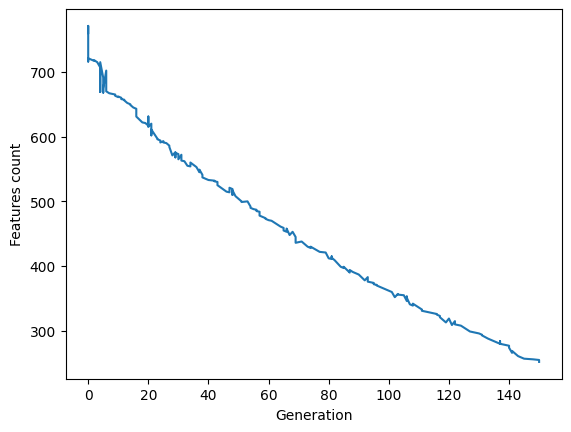

In [11]:
stats = np.array(stats)
plt.plot(stats[:,0],stats[:,1])
plt.xlabel("Generation")
plt.ylabel("Features count")

plt.show()

### Sort features by importance

In [12]:
x_train = checked_data
y_train = train["Survived"]

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# K = np.abs(list(model.coef_))
K = pd.DataFrame({ 'Name':checked_data.columns, 'w': model.coef_[0] })
K['w'] = K['w'].abs()
K = K.sort_values(by=['w'], ascending=False)

K.head(10)

,Name,w
1,Age,1.602471
23,Name_mr,1.434207
102,Name_mad,1.239708
7,Cabin_26,1.218698
249,Sex_male,1.173185
32,Name_pal,1.124054
115,Name_rev,1.085970
251,Pclass_3,1.046235
44,Name_jul,0.984631
188,Name_hed,0.910247


In [13]:
# Sort columns by importance
checked_data = checked_data[K['Name']]
checked_data

,Age,Name_mr,Name_mad,Cabin_26,Sex_male,Name_pal,Name_rev,Pclass_3,Name_jul,Name_hed,...,Name_vig,Name_es,Cabin_64,Name_soh,Name_fra,Name_joe,Name_atk,Name_gwa,Name_end,Cabin_51
0,0.176000,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.304000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.208000,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.280000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.280000,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.216000,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887,0.152000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
888,0.237593,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
889,0.208000,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train model

In [14]:
# x_train, x_test, y_train, y_test = train_test_split(
#     checked_data, train["Survived"], test_size=0.2, random_state=42
#     )
x_train = checked_data
y_train = train["Survived"]

# model = LogisticRegression(max_iter=1000)
# model.fit(x_train, y_train)

# model = BaggingClassifier(LogisticRegression(max_iter=1000,random_state = 42),
#                           n_estimators=7,
#                           bootstrap = True,
#                           random_state = 2024)
# model = RandomForestClassifier(n_estimators=7, max_depth=7,  random_state=2024)
estimators = [('lr', BaggingClassifier(LogisticRegression(max_iter=1000,random_state = 2024),
                          n_estimators=5,
                          bootstrap = True,
                          random_state = 2024)), 
              ('dt', RandomForestClassifier(n_estimators=5, max_depth=5,  random_state=2024))]
model = StackingClassifier(estimators=estimators, final_estimator=SVC(random_state=2024))
model.fit(x_train, y_train)

# Make predictions
# print("Accuracy of the model = %.2f" % model.score(x_test, y_test))

StackingClassifier(estimators=[('lr',
                                BaggingClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                               random_state=2024),
                                                  n_estimators=5,
                                                  random_state=2024)),
                               ('dt',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=5,
                                                       random_state=2024))],
                   final_estimator=SVC(random_state=2024))

### Test model

In [15]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test_passengerIds = test['PassengerId'].values
# test_passengerIds

In [16]:
x_test = process_data(test)

x_test = x_test[x_test.columns.intersection(checked_data.columns)]
print('%d from %d features used in test' % (len(x_test.columns),len(checked_data.columns)))
print(list(checked_data.columns.intersection(x_test.columns)))
#Not used features set to 0
for col in checked_data.columns.difference(x_test.columns):
  x_test[col] = 0

#test columns sorting by train dataframe for model
x_test = x_test[checked_data.columns]
print('All features in model')
print(list(x_test.columns))
y_pred = model.predict(x_test)
# print(y_pred)

153 from 252 features used in test
['Age', 'Name_mr', 'Cabin_26', 'Sex_male', 'Name_pal', 'Name_rev', 'Pclass_3', 'Name_jul', 'Pclass_1', 'Name_tts', 'Name_ish', 'Cabin_D', 'Name_ac', 'Name_ene', 'Cabin_96', 'Name_ton', 'Name_jac', 'Name_nch', 'Name_nn', 'Name_kla', 'Name_eme', 'Name_est', 'Name_han', 'Cabin_82', 'Name_hal', 'Name_ols', 'Cabin_46', 'Name_edv', 'Name_nk', 'Name_cal', 'Name_kat', 'Name_bee', 'Name_tra', 'Name_oug', 'Name_pau', 'Cabin_92', 'Name_ama', 'Name_taf', 'Name_asp', 'Name_lie', 'Name_lor', 'Cabin_10', 'Name_ine', 'Name_can', 'Name_rt', 'Name_ena', 'Name_hol', 'Name_man', 'Name_lam', 'Cabin_4', 'Name_isi', 'Name_nie', 'Name_nni', 'Name_cas', 'Name_fro', 'Cabin_G', 'Name_pet', 'Fare', 'Cabin_77', 'Name_cam', 'Name_emm', 'Name_fle', 'Name_ick', 'Name_lio', 'Name_ust', 'Name_ano', 'Name_dez', 'Name_phi', 'Name_sha', 'Name_and', 'Name_ffo', 'Name_den', 'Name_jes', 'Name_mrs', 'Name_ger', 'Name_sy', 'Name_smi', 'Name_lun', 'Name_vir', 'Name_ebo', 'Name_tun', 'Name_may'

In [17]:
output = pd.DataFrame({'PassengerId':test_passengerIds, 'Survived': y_pred})
output.to_csv('submission.csv', index=False)

In [18]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
